In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
snyk_df_P0 = pd.read_csv("eval/results/security/P0/snyk_code_P0.csv")

snyk_df_P1 = pd.read_csv("eval/results/security/P1/snyk_code_P1.csv")

snyk_df_P2 = pd.read_csv("eval/results/security/P2/snyk_code_P2.csv")

snyk_df_P3 = pd.read_csv("eval/results/security/P3/snyk_code_P3.csv")

snyk_df_req = pd.read_csv("eval/results/security/requests/snyk_code_utils_filtered.csv")


snyk_dfs = [
    ("P0", snyk_df_P0),
    ("P1", snyk_df_P1),
    ("P2", snyk_df_P2),
    ("P3", snyk_df_P3),
    ("req", snyk_df_req)
]

In [3]:
def _clean_snyk(df: pd.DataFrame) -> pd.DataFrame:
    required = {"Text"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Snyk CSV missing required columns: {sorted(missing)}")

    out = df.copy()

    # Map new header to old logical name
    out["PROBLEM_TITLE"] = out["Text"].astype(str).str.strip()

    # drop empty titles if any
    out = out[
        out["PROBLEM_TITLE"].ne("") &
        out["PROBLEM_TITLE"].ne("nan")
    ]

    return out


In [4]:
# --- Build count table: # findings per PROBLEM_TITLE per strategy ---
count_frames = []
for strategy, df in snyk_dfs:
    df = _clean_snyk(df)
    c = (
        df.groupby("PROBLEM_TITLE")
          .size()
          .rename(strategy)
          .to_frame()
    )
    count_frames.append(c)

vuln_counts = pd.concat(count_frames, axis=1).fillna(0).astype(int)

# Add totals with unambiguous wording
col_total_name = "Total findings (across all strategies)"
row_total_name = "Total findings (all vulnerabilities)"

vuln_counts[col_total_name] = vuln_counts.sum(axis=1)
vuln_counts.loc[row_total_name] = vuln_counts.sum(axis=0)

# --- Ensure total row stays at the bottom ---
total_row = vuln_counts.loc[[row_total_name]]
vuln_only = vuln_counts.drop(index=row_total_name)

paper_vuln_counts = pd.concat([
    vuln_only.sort_values(by=col_total_name, ascending=False),
    total_row
])

paper_vuln_counts


,P0,P1,P2,P3,req,Total findings (across all strategies)
PROBLEM_TITLE,,,,,,
Use of Hardcoded Credentials,3,1,2,4,0,10
Use of Hardcoded Passwords,2,1,1,3,1,8
Use of Password Hash With Insufficient Computational Effort,0,0,0,3,0,3
Total findings (all vulnerabilities),5,2,3,10,1,21


In [5]:
# Print table in template required latex form (keeps index as first column)
def df_to_latex_tabular_vuln(df: pd.DataFrame, index_name: str = "Vulnerability") -> str:
    cols = df.columns.tolist()

    # 1 extra column for the index
    col_format = "|l|" + "|".join(["c"] * len(cols)) + "|"

    lines = []
    lines.append(f"\\begin{{tabular}}{{{col_format}}}")
    lines.append("\\hline")

    # Header: index column name + data columns
    header = " & ".join([index_name] + cols) + " \\\\"
    lines.append(header)
    lines.append("\\hline")

    # Rows: index value first, then row values in column order
    for idx, row in df.iterrows():
        row_str = " & ".join([str(idx)] + [str(v) for v in row.values]) + " \\\\"
        lines.append(row_str)
        lines.append("\\hline")

    lines.append("\\end{tabular}")
    return "\n".join(lines)

latex_tabular = df_to_latex_tabular_vuln(paper_vuln_counts, index_name="PROBLEM\\_TITLE")
print(latex_tabular)


\begin{tabular}{|l|c|c|c|c|c|c|}
\hline
PROBLEM\_TITLE & P0 & P1 & P2 & P3 & req & Total findings (across all strategies) \\
\hline
Use of Hardcoded Credentials & 3 & 1 & 2 & 4 & 0 & 10 \\
\hline
Use of Hardcoded Passwords & 2 & 1 & 1 & 3 & 1 & 8 \\
\hline
Use of Password Hash With Insufficient Computational Effort & 0 & 0 & 0 & 3 & 0 & 3 \\
\hline
Total findings (all vulnerabilities) & 5 & 2 & 3 & 10 & 1 & 21 \\
\hline
\end{tabular}


In [6]:
import os

def save_latex(path: str, content: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f:
        f.write(content)

#Save table txt in the repository
save_latex(
    "latex/tables/API/security.tex",
    latex_tabular
)

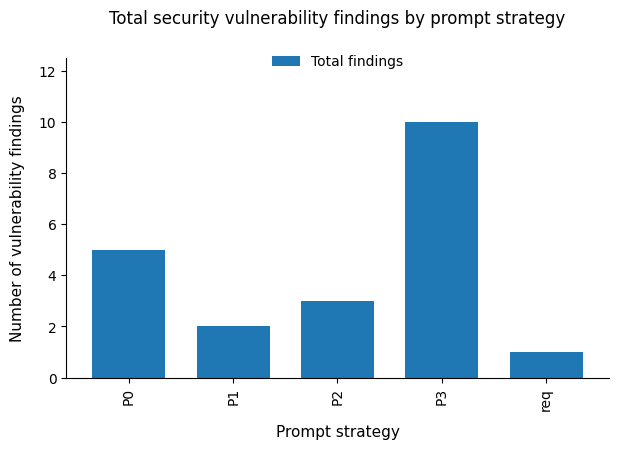

In [7]:
# Graph: total vulnerability findings per strategy

import matplotlib.pyplot as plt

# Extract totals row (drop the rightmost "all strategies" column)
row_total_name = "Total findings (all vulnerabilities)"
col_total_name = "Total findings (across all strategies)"

plot_df = (
    paper_vuln_counts
    .loc[row_total_name]
    .drop(col_total_name)
    .to_frame(name="Total findings")
)

fig, ax = plt.subplots(figsize=(7, 4.5))

plot_df.plot(
    kind="bar",
    ax=ax,
    width=0.7
)

ax.set_ylabel("Number of vulnerability findings", fontsize=11, labelpad=10)
ax.set_xlabel("Prompt strategy", fontsize=11, labelpad=10)

ax.set_title(
    "Total security vulnerability findings by prompt strategy",
    pad=25
)

ax.set_ylim(0, plot_df.max().max() * 1.25)

ax.legend(
    ["Total findings"],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    frameon=False
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.subplots_adjust(top=0.82)

# Save image in the repository
plt.savefig(
    "latex/figures/API/vulnerability_findings_bar.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


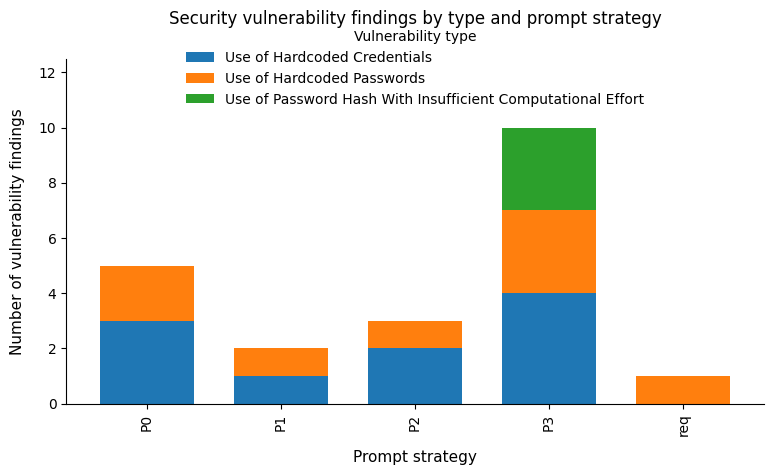

In [8]:
# Stacked bar chart: vulnerability types by strategy (all types)

import matplotlib.pyplot as plt

row_total_name = "Total findings (all vulnerabilities)"
col_total_name = "Total findings (across all strategies)"

# Build plot matrix (rows: strategies, columns: vulnerability types)
plot_df = (
    paper_vuln_counts
    .drop(index=row_total_name)
    .drop(columns=col_total_name)
    .T  # strategies on x-axis
)

fig, ax = plt.subplots(figsize=(9, 5))

plot_df.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    width=0.7
)

ax.set_ylabel("Number of vulnerability findings", fontsize=11, labelpad=10)
ax.set_xlabel("Prompt strategy", fontsize=11, labelpad=10)

ax.set_title(
    "Security vulnerability findings by type and prompt strategy",
    pad=25
)

ax.set_ylim(0, plot_df.sum(axis=1).max() * 1.25)

ax.legend(
    title="Vulnerability type",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.12),
    frameon=False
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.subplots_adjust(top=0.8)

# Save image in the repository
plt.savefig(
    "latex/figures/API/vulnerability_stacked_bar.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()
